# BBC - Projet
## Diagnostic miARN pour détecter le cancer de la prostate

- Professeur: Carlos Peña (<a href="mailto:carlos.pena@heig-vd.ch">carlos.pena@heig-vd.ch</a>)
- Assistante: Aitana Lebrand (<a href="mailto:aitana.nevesdasilva@heig-vd.ch">aitana.nevesdasilva@heig-vd.ch</a>)
- Etudiant: Jan Purro (<a href="mailto:jan.purro@heig-vd.ch">jan.purro@heig-vd.ch</a>)
- Etudiant: Thibault Schowing (<a href="mailto:thibault.schowing@heig-vd.ch">thibault.schowing@heig-vd.ch</a>)

Date: Printemps 2016

Note: Ce projet est largement inspiré du laboratoire 3-4 de BBC-2016

## Objectifs pédagogiques

L'objectif de ce projet est de mettre en application les notions biologiques et informatiques apprises en cours de semestre.  


## But du projet

Le but du projet est d'analyser des données micro-arrays sur la concentration de micro-ARN dans l'urine de personnes atteintes ou non du cancer de la prostate (résumé PCa dans ce document) afin de pouvoir créer un modèle pour déterminer, à partir d'un nouvel échantillon, si la personne concernée est atteinte de PCa ou non avec un minimum de miARN afin de réduire les coûts du test. 


## Démarche

Dans une première partie, les données seront mises en forme afin de pouvoir être traitées. En suite, par plusieurs méthodes comme la corrélation de Pearson ou le t-test, les gènes ayant une relation entre patients atteints ou non de PCa seront extraits du lot des différents gènes. 

Une fois ces gènes extraits, un modèle d'apprentissage sera entrainé avec un *train set* puis il sera validé avec un *test set*. 


## Rapport de labo



On lit les données depuis le fichier `GSE45604_series_matrix.txt`. Le fichier contenant nombre d'informations pas forcément utiles pour notre travail, nous isolons les données qui nous intéresse.

## Importation des modules

In [1]:
import os
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib
from scipy.stats import norm
import scipy.spatial.distance as ssd
from random import randint
from random import shuffle
from Bio import Geo
# Local module
import stats

%matplotlib inline 

## Définition des fonctions

Définition des fonctions utilisées dans le code. Nous avons placé les fonctions ici dans le but de rendre le code plus lisible. La plupart de ces fonctions sont issus du laboratoire 3-4 du cours BBC.

In [2]:
"""
Function used to compute the correlation to desired_profile for each genes (or miRNA) contained in data.
Print plots of the obtained values.
Firt line and column of data will be ignored (we assume those contains a header respectively identifiers).

Author : Aitana Lebrand
"""
def pearson_genes(data,desired_profile,show_plot=1):
    
    import scipy.stats as ss
    
    correl = [] # contains the correlation for each gene
    correl_p  = [] # for now, do not try to understand what correl_p is...
    
    # loop over genes
    for i in range(np.shape(data)[0]-1): # do not consider first line of data (=header)
        
        gene_expression = data[i+1,1:] # do not consider first  column (= gene identifiers)
        gene_expression = np.array(gene_expression,dtype=float) # convert to float
        
        pearson_corr = ss.pearsonr(gene_expression,desired_profile) # calculate Pearson correlation
        correl.append(pearson_corr[0])
        correl_p.append(pearson_corr[1]) # forget about this for now...
        
    correl = np.array(correl,dtype=float) # convert to array... easier to manipulate
    
    # plot correlation values
    if show_plot:
        fig = plt.figure()
        plt.plot(correl,'bo')
        plt.ylim([-1,1])
        plt.xlim([0,len(correl)])
        plt.xlabel('Gene index')
        plt.ylabel('Pearson correlation')
        plt.show()
        
        plt.figure()
        plt.hist(correl)
        plt.xlabel('Pearson correlation')
        plt.ylabel('Counts')
        plt.xlim([-1,1])
        plt.show()

    return (correl,correl_p)

"""
Function that shuffles a numpy array.
The columns are shuffled (except the first one, which is assumed to contain identifiers).

Author : Aitana Lebrand
"""
def shuffle_data(data):
    
    # get shuffled columns indexes
    shuffled_idx = range(1,np.shape(data)[1]) # ! do not shuffle the first colum (= gene identifiers)
    shuffle(shuffled_idx) # shuffled_idx is now shuffled
    #print (shuffled_idx)
    shuffled_idx.insert(0,0)

    # use shuffled_idx to randomize the columns of data
    data_random = data[:,shuffled_idx]
    data_random[0,:] = data[0,:] # put label conditons on top again

    return data_random

"""
Builds and display a plot representing the genes or miARNs expresssion depending on the patient condition.

Author : Aitana Lebrand
"""

def show_matrix_expression(data,idx_genes,dim=(16,10),show_ylabels=True):
    
    import matplotlib
    import scipy.cluster.hierarchy as cl
    import scipy.spatial.distance as ssd
    
    # data: matrix of data with headers
    # idx_genes: idx of genes 
    
    if isinstance(idx_genes,list):
        idx_genes = np.array(idx_genes,dtype=int)
    
    conditions = data[0,1:]
    genes = data[1:,0]
    print(genes)
    data_to_show = data[idx_genes,1:]
    
    # re-order genes using hierarchical clustering
    fig = plt.figure(num=None,figsize=(dim),dpi=250) 
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
    dmat = ssd.pdist(data_to_show,'cosine')
    Z = cl.linkage(ssd.squareform(dmat),method='average',metric='cosine')
    Z = cl.dendrogram(Z,orientation='left',no_labels=True)
    idx_reorder = Z['leaves']
    data_to_show = data_to_show[idx_reorder,:]    
    
    # plot heatmap
    ax = fig.add_axes([0.3,0.1,0.6,0.6])
    heatmap = ax.pcolor(data_to_show, cmap=plt.cm.YlGnBu,vmin=15,vmax=110)
    
    ## pour faire joli...............................................................................
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data_to_show.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(data_to_show.shape[0])+0.5, minor=False)

    # frame and labels position...
    ax.set_frame_on(False)
    ax.xaxis.tick_top()
    ax.grid(False)
    plt.xlim([0,np.shape(data_to_show)[1]])
    plt.ylim([0,np.shape(data_to_show)[0]])

    # set xlabels and ylabels
    if show_ylabels:
        ax.set_yticklabels([genes[ii+1] for ii in idx_genes], minor=False) 
    else:
        ax.yaxis.tick_right()
        ax.set_yticklabels([genes[ii+1] for ii in idx_genes])
    #conditions = [id_cond[s] for s in conditions]
    ax.set_xticklabels(conditions, minor=False)

    # rotate tick labels and set size
    plt.xticks(rotation=90) # rotate xlabels
    matplotlib.rcParams['xtick.labelsize'] = 10
    
    plt.show()
    
"""
Function training a kNN classifier with a training set of data. The classifier is then tested with another set of data
(which must be different from the first one to make sense).
The score of the classifier (what proportion of the test data was correctly classified) is returned.

Author : Aitana Lebrand
"""
def kNN_classifier(X,y,X_test,y_test):
    
    from sklearn import neighbors
    
    # train de kNN classifier
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X, y)

    # predict on the test set
    pred_kNN = clf.predict(X_test)
    
    # return score
    score = clf.score(X_test,y_test)
    return score


"""
Function fitting a SVM classifier with a training set of data. The classifier is then tested with another set of data
(which must be different from the first one to make sense).
The score of the classifier (what proportion of the test data was correctly classified) is returned.

Author : Aitana Lebrand
"""
def SVM_classifier(X, y, X_test, y_test):
    
    from sklearn import svm
    
    clf = svm.SVC()
    clf.fit(X, y)
    
   
    pred_svm = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    
    return score

"""
Function training a random forest classifier with a training set of data. The classifier is then tested with another set of data
(which must be different from the first one to make sense).
The score of the classifier (what proportion of the test data was correctly classified) is returned.

Author : Aitana Lebrand
"""
def RandomForest_classifier(X, y, X_test, y_test):
    
    # Import the random forest package
    from sklearn.ensemble import RandomForestClassifier 
    
    # Create the random forest object which will include all the parameters
    # for the fit
    forest = RandomForestClassifier(n_estimators = 100)

    # Fit the training data to the Survived labels and create the decision trees
    forest = forest.fit(X,y)

    # Take the same decision trees and run it on the test data
    pred_RandForest = forest.predict(X_test)
    
    score = forest.score(X_test, y_test)
    return score


"""
Function returning a list of size elements. Each element is unique its value is an integer between minimum and maximum.

Author : Jan Purro
"""
def random_generator(size, minimum, maximum):
    assert size <= maximum - minimum
    tab = []
    for i in range(size):
        r = randint(minimum, maximum-1)
        while r in tab:
            r = randint(minimum, maximum-1)
        tab.append(r)
    return sorted(tab)

## Lecture des données

On lit les données contenues dans le fichier `GSE45604_series_matrix.txt`.

Le but est d'obtenir une matrice contenant le niveau d'expression des miARNs pour chaque patient.
Les colonnes de la matrice sont réarangées afin de mettre les patients dont la condition est "normale" en premier et les patients souffrant du cancer de la prostate (PCa) ensuite.

In [3]:
# Reading file
records_matrix = open('../data/GSE45604_series_matrix.txt')

# Reading the data (expression of miRNAs), with the header indicate the patient id.
matrice =  [l.strip().split('\t') for l in records_matrix.readlines()[67:-1]]

# Reading the patients conditons (we suppose that the order correspond to the data header)
records_matrix.seek(0)
conditions = records_matrix.readlines()[34].strip().split('\t')

# Conversion of read lists to ndarrays.
matrice = np.array(matrice)
conditions = np.array(conditions[1:])


# We have two types of cells : cells from patients suffering of protratic cancer and cells from healthy patients.
# We are going to mark them respectively 'PCa' and 'Normal'
idx_normal = []
idx_pca = []
i = 1
for c in conditions:
    if c.startswith('"PCa'):
        matrice[0,i] = 'PCa'
        idx_pca.append(i)
    else:
        matrice[0,i] = 'Normal'
        idx_normal.append(i)
    i += 1

# We order the indices, placing the normal patient first and PCa patient after.
idx_ordered = [0] + idx_normal + idx_pca

# Reordering the matrice.
matrice = matrice[:,idx_ordered]

# Closing file (we don't need it anymore)
records_matrix.close()

On sépare le dataset en deux sous-ensembles :

- Test: Données qui ne seront pas prise en compte pour créer le model mais uniquement pour le valider.


- Train: Données (plus nombreuses que le test set) qui seront utilisée pour entrainer le modèle. 


In [4]:
# We select a bunch of indices (of both healthy and sick patients) to serve as the test data set.
idx_test = [5,9,19,28,32,48,60]

# The remaining indices will be used to train our classifiers.

idx_train = range(0,len(matrice[0]))
[idx_train.remove(i) for i in idx_test]

# Both sets must contain the 0 index (identifiers).
idx_test = [0,5,9,19,28,32,48,60]

# We create both sets from the matrice.
data_test = matrice[:,idx_test]
data = matrice[:,idx_train]

Pour identifier les gènes exprimés différemment chez les patients cancéreux des patients normaux, nous allons comparer l'expression de chaque gène par rapport à un profile désiré. On cherche un profil où l'expression d'un gène est significativement différente entre un patient sain et un patient cancéreux.

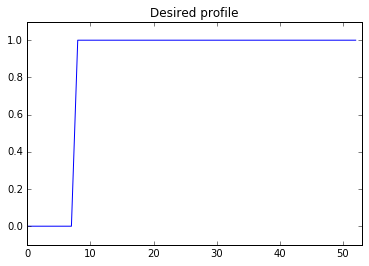

In [5]:
# We create the desired profile, both for the training and testin sets.
desired_profile = [1 if s =='PCa' else 0 for s in data[0,1:]]
desired_profile_test = [1 if s =='PCa' else 0 for s in data_test[0,1:]]


# Plot of the desired profile.
fig = plt.figure()
plt.plot(desired_profile)
plt.ylim([-0.1,1.1])
plt.xlim([0,len(desired_profile)])
plt.title('Desired profile')
plt.show()


Ci-dessous, nous allons chercher la corrélation de pearson, entre l'expression des gènes individuels et le profil désiré. Plus une valeur est proche de 1, plus la corrélation est forte, une valeur négative indiquant une corrélation inverse (ce qui nous intéresse aussi, bien évidemment). Une valeur proche de 0 indique une absence de corrélation.

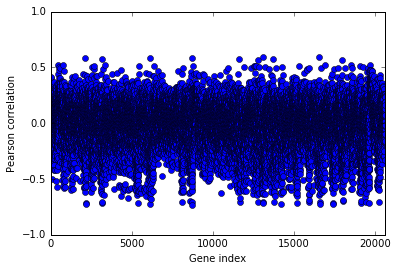

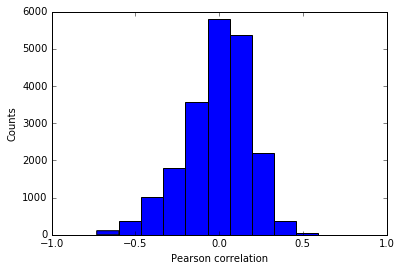

In [6]:
# Computing the correlation of all miRNAs and printing a plot of the restults.
co = pearson_genes(data,desired_profile)
corr = co[0]

Nous constatons que, malheureusement, il y a peu de gènes qui soient fortement corrélés ou inversemment corrélés. On peut tout de même noté que quelques gènes s'approchent d'une corrélation de -0.5, qui pourraient éventuellement être utilisé.

Afin de vérifier que les gènes corrélés ne sont pas simplement le fruit du hasard, nous allons maintenant randomiser les données, afin de comparer la corrélation de l'expression des gènes aléatoires avec celle du set de données.

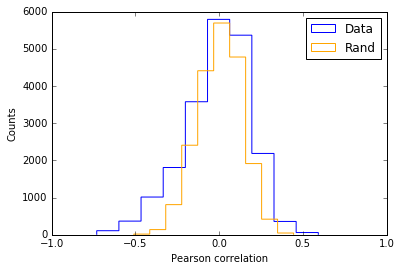

In [7]:
# Shuffling the columns.
data_random = shuffle_data(data)

# We compute the random data correlations
co_rand = pearson_genes(data_random, desired_profile,0)
corr_rand = co_rand[0]

# We plot both sets correlations
plt.figure()
plt.hist(corr, histtype='step', stacked=True, color=['Blue'], label=['Data'])
plt.hist(corr_rand, histtype='step', stacked=True, color=['Orange'], label=['Rand'])
plt.xlabel('Pearson correlation')
plt.ylabel('Counts')
plt.xlim([-1,1])
plt.legend()

plt.show()

On peut constater que les données aléatoires sont très très légèrement moins corrélées ques les données originales. 

Toutefois, afin de confirmer que c'est bien le cas, il s'agit de randomiser plusieurs fois le set de données et de faire la moyenne de ses randomisations et de les comparer avec le set de base.

In [8]:
# Multiple randomization, as it takes some time the result is saved inside a file, if the file already exists, 
# the file is used instead.

N_genes = np.shape(data)[0]-1 
N_random = 200
corr_random = np.empty((N_genes,N_random),dtype=float) 


# We try to open the file, if it fails we do the randomization and save it in the file. 
try :
    corr_random = np.load('corr_randomized.npy')

except IOError:
    print("Loading...")
    for i in range(0, N_random ):
        data_rand = shuffle_data(data)
        correlation = pearson_genes(data_rand, desired_profile,0)
        patate = correlation[0]
        print("Pass "+ str(i+1)+ "/"+ str(N_random))
        corr_random[:,i] = patate

    print("\nDone !! \nCorr_random: ")
    print(corr_random)

    np.save('corr_randomized.npy', corr_random)

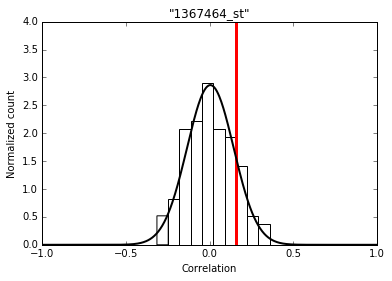

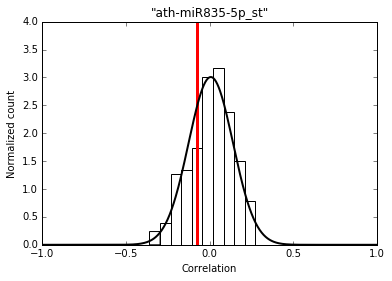

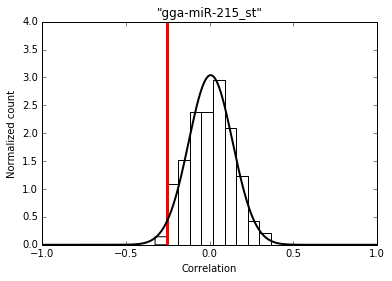

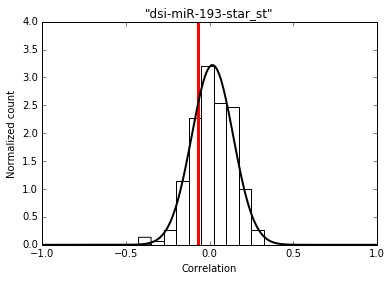

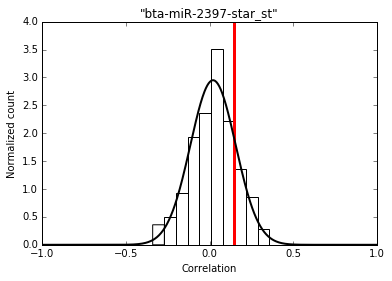

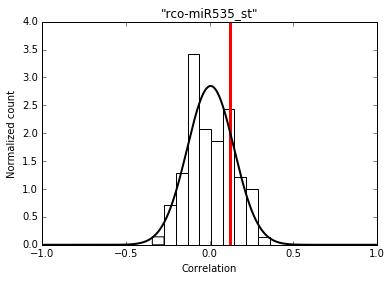

In [9]:

# Show results only for these genes
idx_genes_to_show = [12,1181,8590,5592, 2345,17836] 

# Plot: loop over idx_genes_to_show
for idx in idx_genes_to_show: 
    fig = plt.figure()
    random_correlations = corr_random[idx,:]
    plt.hist(random_correlations,normed=True,color='w')
    plt.vlines(corr[idx],0,4,'r',lw=3) # Observed value
    plt.title(data[idx+1,0]) # miRNA name
    plt.xlim([-1,1])
    plt.ylim([0, 4])
    plt.xlabel('Correlation')
    plt.ylabel('Normalized count')
    
    # fit gaussian to distribution of correlations from randomized data
    xx = np.linspace(-1,1,500)
    mu = np.mean(random_correlations)
    sigma = np.std(random_correlations)
    plt.plot(xx,norm.pdf(xx,loc=mu,scale=sigma),'k-',lw=2)

On peut constater que pour certains gènes, (inversemment) corrélés dans le set de données originales, il n'y a pas de corrélation dans les données randomisées 200 fois. On peut donc assumer que ces corrélations ne sont pas seulement des données chanceuses.

Ci-dessous nous calculons la *p-value* de chaque corrélation, afin de connaître la probabilité que la corrélation soit issue de la même distribution que les données aléatoire.

In [10]:
# Number of genes in the data
N_genes = np.shape(data)[0]-1 

# p-values 
pval_correl = []
for idx in range(0,N_genes):
    
    # Random correlation: calculate mean and standard deviation
    
    random_correlations = corr_random[idx,:]
    mean_random = np.mean(random_correlations)
    std_random = np.std(random_correlations)
    
    # Observed correlation
    observed_correlation = corr[idx]
    
    # CDF: cumulative distribution function = integral of the gaussian distribution from -inf to observed_correlation
    cdf = norm.cdf(observed_correlation,loc=mean_random,scale=std_random)
    
    if cdf >= 0.5:
        p = 1 - cdf
    else:
        p = cdf
    pval_correl.append(2*p) # factor 2 because correlations can take both positive and negative values

('fdr_pval: ', 7.0746723075723561e-06)
-log10(p-value FDR) = 5.15029367147



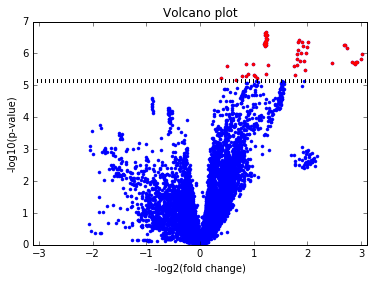

61 significant mi-RNA found with correlation (after p-value correction): 
['"bta-miR-187_st"' '"bta-miR-221_st"' '"bta-miR-224_st"'
 '"cfa-miR-187_st"' '"cfa-miR-221_st"' '"cfa-miR-224_st"'
 '"cfa-miR-421_st"' '"dan-miR-100_st"' '"dmo-miR-100_st"'
 '"dre-miR-187_st"' '"dre-miR-221_st"' '"dre-miR-222b_st"'
 '"dya-miR-100_st"' '"eca-miR-187_st"' '"eca-miR-221_st"'
 '"eca-miR-224_st"' '"eca-miR-301a_st"' '"fru-miR-187_st"'
 '"fru-miR-221_st"' '"gga-miR-187_st"' '"gga-miR-221_st"'
 '"ggo-miR-187_st"' '"ggo-miR-221_st"' '"ggo-miR-224_st"'
 '"hsa-miR-187_st"' '"hsa-miR-221_st"' '"hsa-miR-224_st"'
 '"hsa-miR-362-3p_st"' '"hvt-miR-H14-star_st"' '"mdo-miR-100_st"'
 '"mdo-miR-187_st"' '"mdo-miR-221_st"' '"mml-miR-187_st"'
 '"mml-miR-221_st"' '"mml-miR-224_st"' '"mmu-miR-187_st"'
 '"mmu-miR-221_st"' '"mmu-miR-24-1-star_st"' '"mne-miR-187_st"'
 '"mne-miR-224_st"' '"oan-miR-187_st"' '"oan-miR-221_st"'
 '"ppa-miR-187_st"' '"ppa-miR-221_st"' '"ppa-miR-224_st"'
 '"ppy-miR-187_st"' '"ppy-miR-221_st"' '

In [11]:
# Multiple-testing-corrected p-value
fdr_pval = stats.fdr_correction(pval_correl, 0.025)
print("fdr_pval: ", fdr_pval)
print('-log10(p-value FDR) = '+str(-np.log10(fdr_pval))+'\n')

# idx of genes with p-value < fdr_pval
idx_sg_corr = np.array([i for i,p in enumerate(pval_correl) if p<fdr_pval])

# Volcano plot that shows significant genes in red
stats.volcano_plot(data[1:,1:],desired_profile,pval=pval_correl,idx=idx_sg_corr)

# Print name of most significant genes
print(str(len(idx_sg_corr))+' significant mi-RNA found with correlation (after p-value correction): \n'+str(data[idx_sg_corr+1,0]))

Nous pouvons constater que 61 miARNs ont une *p-valeur* suffisamment petite pour être pris en compte.

Ci-dessous nous affichons une *heatmap* afin de visualiser l'expression de ces miARNs selons les le type de cellule (cancéreuse ou normal).

['"1367452_st"' '"1367453_st"' '"1367454_st"' ..., '"zma-miR529_st"'
 '"zma-miR827-star_st"' '"zma-miR827_st"']


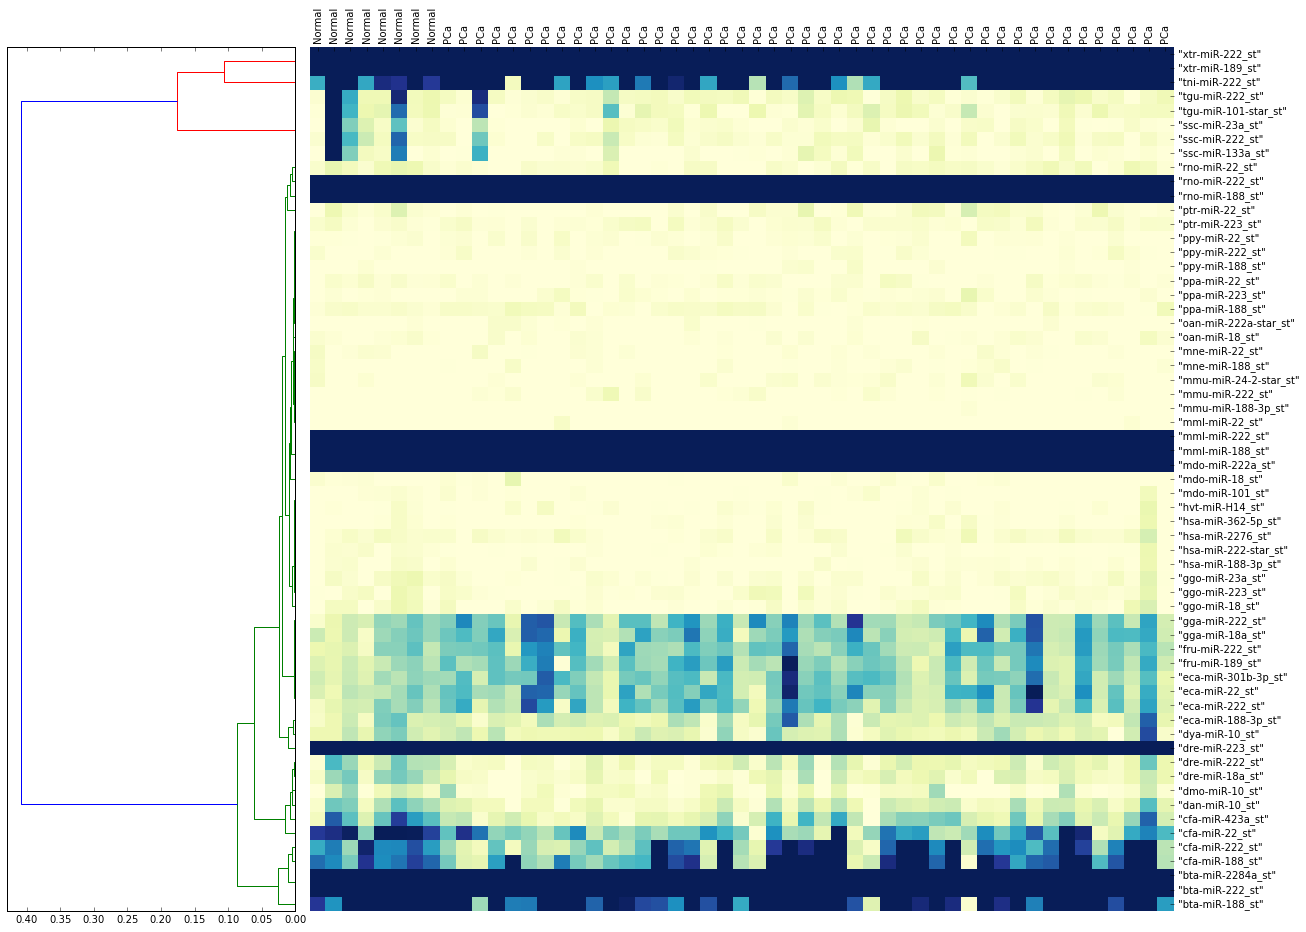

In [12]:
show_matrix_expression(data,idx_sg_corr,dim=(20,20),show_ylabels=False)

In [13]:
# t-test
################

from scipy.stats import ttest_ind

# Number of miRNA
N_genes = np.shape(data)[0]-1

# Column idx with Prostatic cancer
idx_PCa = [i for i,c in enumerate(data[0,1:]) if data[0,i]=='PCa'] 
cell_type = ['Normal','PCa']

# Perform t-test between cancer cell type and normal cell type
pval_ct = [] # p-value across cell types
for k,ct in enumerate(cell_type[:-1]):  
    
    idx_normal = [i for i,c in enumerate(data[0,1:]) if data[0,i]==ct] # column idx corresponding to a cell type
    pval = []
    for g in range(1,N_genes+1): # loop over genes
    
        normal = np.array(data[g,idx_normal],dtype=float)
        PCa = np.array(data[g,idx_PCa],dtype=float)
        ttest = ttest_ind(PCa,normal,equal_var=True) # return t-value and its associated p-value
        #equal_var : bool, optional If True (default), perform a standard independent 2 sample test 
        #that assumes equal population variances [R315]. 
        #If False, perform Welch’s t-test, which does not assume equal population variance [R316].
        pval.append(ttest[1])
    pval_ct.append(pval)


In [14]:
# fdr correction
reload(stats)
fdr_pval = [stats.fdr_correction(pval_ct[ct],0.025) for ct in range(len(pval_ct))]

#print("fdr_pval: ", fdr_pval)

# keep genes for which the t-test p-value is smaller than the fdr-corrected threshold (fdr_pval)
idx_sg_ttest = []
for i in range(N_genes):
    significant = [1 if pval_ct[ct][i]<fdr_pval[ct] else 0 for ct in range(len(pval_ct))]
    # On compare avec 1 condition (PCa vs Normal)
    if sum(significant)==1:
        idx_sg_ttest.append(i)

# keep only genes that appear significantly in each t-test AND in the correlation test

# Vérification s'il y a des gènes en commun entre les deux méthodes

idx_sg_ttest = np.array(idx_sg_ttest)

print("nb gene from correlation: ", len(idx_sg_corr))

print("nb gene from ttest: ", len(idx_sg_ttest))

# Le t-test n'est pas très utile ici car tous les gènes qu'il sélectionne sont déjà partie du test de Pearson. 

idx_sg_final = np.array( list( set(idx_sg_ttest) & set(idx_sg_corr) ) )

idx_sg_final.sort()
print("Nb final genes: ", len(idx_sg_final))


('nb gene from correlation: ', 61)
('nb gene from ttest: ', 237)
('Nb final genes: ', 61)


On a maintenant 61 miARN sélectionnée qui sont le résultat de la concaténation des meilleurs miARN séléctionnés par les méthode de la corrélation et du t-test. 

## Représentation de la corrélation et du t-test

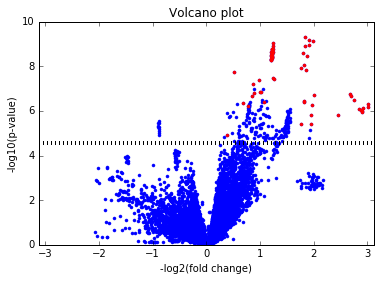

In [15]:
stats.volcano_plot(data[1:,1:],desired_profile,idx=idx_sg_corr)

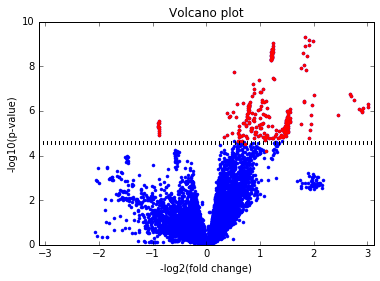

In [16]:
stats.volcano_plot(data[1:,1:],desired_profile,idx=idx_sg_ttest)

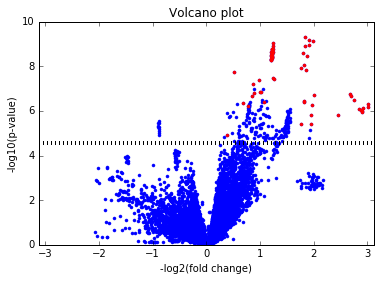

('nombre de micro-ARN pris en compte: ', '61')


In [17]:
stats.volcano_plot(data[1:,1:],desired_profile,idx=idx_sg_final)
print("nombre de micro-ARN pris en compte: ", str(len(idx_sg_final)))

## Construction des classificateurs pour développer un outil diagnostique

In [18]:
# X is the training set transposed to fit the classifier expectation.
X = data[idx_sg_final,1:]
X = np.transpose(X) 
y = desired_profile

# X_test is the testin set also transposed
X_test = data_test[idx_sg_final,1:]
X_test = np.transpose(X_test)
y_test = desired_profile_test

In [19]:
# We try different classifier (kNN, SVM and random forest)
score = kNN_classifier(X,y,X_test,y_test)
print(score)

score = SVM_classifier(X,y,X_test, y_test)
print(score)

score = RandomForest_classifier(X,y,X_test, y_test)
print(score)
print('Le classificateur kNN fait '+str(round(100*score))+'% de prédictions correctes (sur le test set).')

0.714285714286
0.714285714286
0.714285714286
Le classificateur kNN fait 71.0% de prédictions correctes (sur le test set).


Le classificateur réussi à seulement 71% les prédictions avec les 61 miARN. Il faut éliminer le bruit que peut générer certain micro-ARN. 

## Matrice des distances entre chaque condition

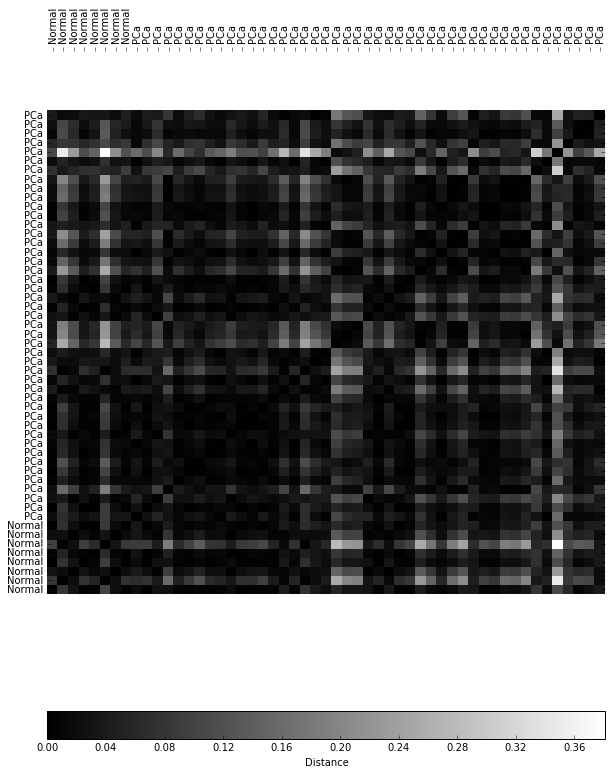

In [20]:
# Calculate distance between any two conditions in X
D = ssd.pdist(X,'cosine')
Ds = ssd.squareform(D)

# Creating plot to show the results
fig, ax = plt.subplots(num=None,figsize=(10,14),dpi=250) 
heatmap = ax.pcolor(Ds, cmap=plt.cm.gray)

ax.set_xticks(np.arange(Ds.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(Ds.shape[0])+0.5, minor=False)

ax.set_frame_on(False)
ax.xaxis.tick_top()
ax.grid(False)
plt.xlim([0,np.shape(Ds)[1]])

labels = [cell_type[s] for s in desired_profile]
ax.set_yticklabels(labels, minor=False) 
ax.set_xticklabels(labels, minor=False)

plt.xticks(rotation=90)
matplotlib.rcParams['xtick.labelsize'] = 10

cbar = fig.colorbar(heatmap, orientation='horizontal')
cbar.set_label('Distance')

## Calcul des scores par paire de mi-ARN
Afin de réduire le nombre de micro-ARN nécessaire mais aussi de réduir un éventuel bruit, nous alons diminuer le nombre de micro-ARN en ne prenant que ceux qui ont le score le plus haut par pair. 

Heatmap des scores par paires: 


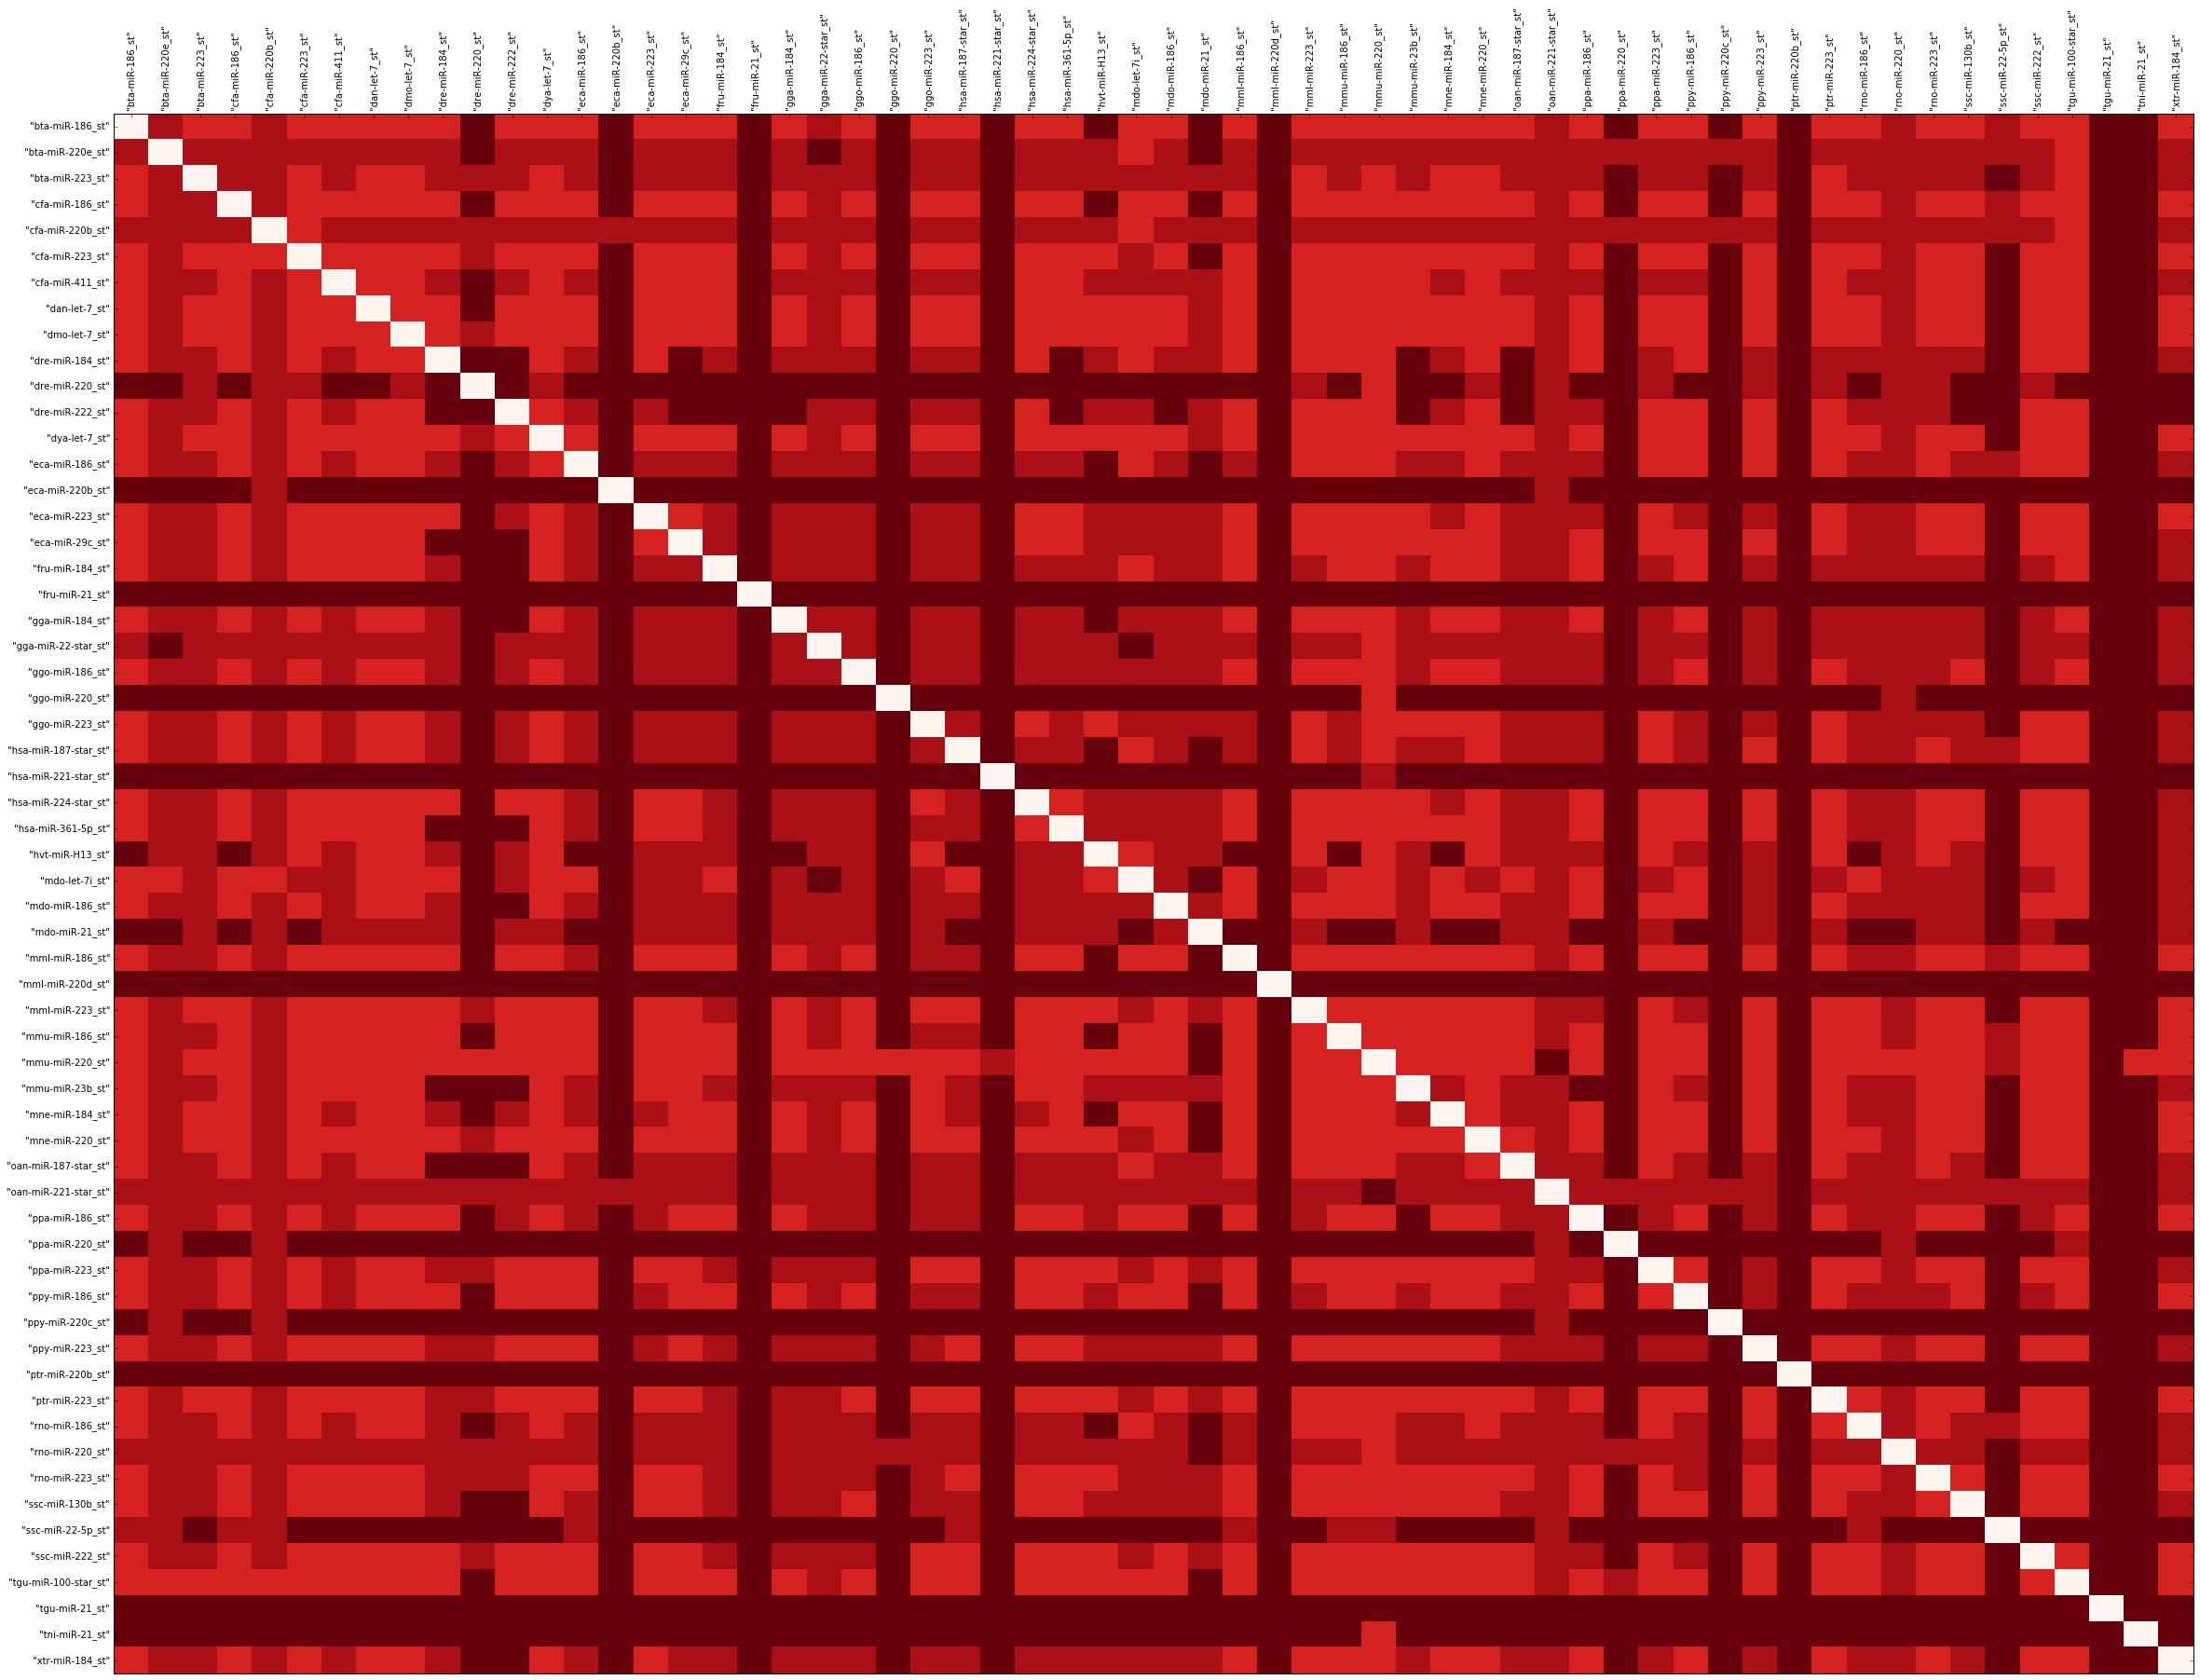

In [21]:
tab_score = []
tab_pair_idx = []
tab_pair = []

# scores_genes is map between the indices of idx_sg_final and the sum of their score
scores_genes = dict()

# Creation of a list containing all possible pairs of indices from idx_sg_final
for i in range(0,len(idx_sg_final)-1):
    scores_genes[idx_sg_final[i]] = 0
    for j in range(i+1,len(idx_sg_final)-1):
        tab_pair_idx.append([idx_sg_final[i], idx_sg_final[j]])

# For each pair, we compute the kNN score
for pairidx in tab_pair_idx:
    
    pairidx = np.array(pairidx)
    
    Xbis = data[pairidx+1, 1:]
    Xbis = np.transpose(Xbis)
    ybis = desired_profile
    
    X_test_bis = data_test[pairidx+1,1:]
    X_test_bis = np.transpose(X_test_bis)
    y_test_bis = desired_profile_test
    
    Score = kNN_classifier(Xbis,ybis,X_test_bis,y_test_bis)
    tab_score.append(Score)
    
    scores_genes[pairidx[0]] += Score
    scores_genes[pairidx[1]] += Score


# Heatmap presenting the results
graphX = graphY = data[idx_sg_final, 0]
graphZ = tab_score

print('================================================================================================================')
print('Heatmap des scores par paires: ')
print('================================================================================================================')

# Graph
Ds2 = ssd.squareform(graphZ)

column_labels = graphX
row_labels = graphY
fig, ax = plt.subplots(figsize=(40, 30))
heatmap = ax.pcolor(Ds2, cmap=plt.cm.Reds)

# Put the major ticks at the middle of each cell
ax.set_xticks(np.arange(Ds2.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(Ds2.shape[1])+0.5, minor=False)


# Want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
plt.xticks(rotation=90)

plt.show()

> Nous ne prenons que les 20 meilleurs



In [22]:
# We convert the map into a list and sort it, accoding to their score.
scores_genes_list = []
for k in scores_genes:
    scores_genes_list.append([scores_genes[k], k])
scores_genes_list.sort()

# We take the best (those with a bigger score, at the end of the list)
idx_best_mirna = [sg[1] for sg in scores_genes_list[-20:]]

In [23]:
# Training set with the new indices
X = data[idx_best_mirna,1:]
X = np.transpose(X) 
y = desired_profile

# Testing set with the new indices
X_test = data_test[idx_best_mirna,1:]
X_test = np.transpose(X_test)
y_test = desired_profile_test

In [24]:
# Run the classifier with the new values
score = kNN_classifier(X,y,X_test,y_test)
print(score)

score = SVM_classifier(X,y,X_test, y_test)
print(score)

score = RandomForest_classifier(X,y,X_test, y_test)
print(score)

0.857142857143
0.714285714286
0.857142857143


Nous avons réussi à réduire le nombre de miARN nécessaires à la classification des patients à 20 miARNs, plutôt que 61. On ne fait toutefois pas mieux que 85.7% de prédictions correctes.  

## Vérification des résultats à l'aide d'un "dummy estimator"
Afin de vérifier si les résultats que nous avons obtenus sont significatifs, et pas seulement le fruit du hasard, nous allons choisir 20 miARN au hasard et voir si nous obtenons des résultats comparables ou moins bons.

In [25]:
# Calcul du score moyen sur 100 experinces avec 20 gènes choisi aléatoirement.
# We run the kNN classifier 100 times with 20 miRNAs chosen randomly.
NB_EXP = 100
scores_20 = []
for i in range(NB_EXP):
    
    # Select random and unique indices.
    miARNs = random_generator(20,0,data.shape[0]-1)
    miARNs = np.array(miARNs)
     
    # Build the training and testing sets
    Xs = data[miARNs+1, 1:]
    Xs = np.transpose(Xs)
    ys = desired_profile
    
    Xs_test = data_test[miARNs+1,1:]
    Xs_test = np.transpose(Xs_test)
    ys_test = desired_profile_test
    
    # Run the classifier
    Score = kNN_classifier(Xs,ys,Xs_test,ys_test)
    scores_20.append(Score)
    
# Print the average of the 100 experiences
print "Moyenne avec 20 miARNs choisis au hasard: ", np.average(scores_20)

Moyenne avec 20 miARNs choisis au hasard:  0.722857142857


On constate avec effarement qu'on obtient une moyenne d'environ 70% de prédictions correctes en choisissant nos miARNs au hasard. Ce sont des meilleurs résultats, en moyenne, qu'en utilisant SVM. Heureusement, les prédictions faites avec l'aide kNN ou d'une random forest donnent des réusltats sensiblement meilleurs.

## Étude du fichier `soft` 
Afin de vérifier si nous avons bien choisi les meilleurs miARNs nous avons étudié le contenue du fichier `.soft`, qui contient, pour chaque patient la valeur observée sur la biopuce de chaque miARN ainsi que leur p-valeur. Nous avons constaté assez rapidement que les miARNs que nous avions choisis n'avaient pas forcément des p-valeurs très petites à l'intérieur de ce fichier.  
Nous avons donc décidé de récupéré les candidats les plus intéressants de ce fichier et de comparer le résultat avec ce que nous avions obtenu précédemment.

In [26]:
# Open the file
soft_file = open("../data/GSE45604_family.soft")

datas_soft = []
n = 0
reading_sample = False
# The first patient result starts at the 20902th line.
# We look for the line indicating the start of a sample table read the values until we reach the line indicating
# the end of the sample table.
for line in soft_file.readlines()[20902:]:
    if line.startswith("!sample_table_begin"):
        datas_soft.append([])
        reading_sample = True
    elif line.startswith("!sample_table_end"):
        n += 1
        reading_sample = False
    # We ignore the header.
    elif reading_sample and not line.startswith('ID_REF'):
        datas_soft[n].append(line.strip().split('\t'))

# Close the file
soft_file.close()

On calcule la moyenne des valeurs observées et des p-valeurs de chaque miARNs à partir des données de tout les patients.

In [27]:
# First with build a list containing sublists with the name of the miARN and the value and p-value (initiaéized at 0)
soft_average = []
for miARN in datas_soft[0]:
    soft_average.append([miARN[0],0.,0.])
    
# We then sum, for each miARNs their value and p-value
for datas in datas_soft:
    n = 0
    for miARN in datas:
        soft_average[n][1] += float(miARN[1])
        soft_average[n][2] += float(miARN[2])
        n += 1

# We calculate the mean by dividing by the number of patients
for miARN in soft_average:
    miARN[1] /= len(datas_soft)
    miARN[2] /= len(datas_soft)

# We sort alphabeticaly the miARNs
soft_average.sort()

# We add a header to the matrice.
soft_average_final = [['ID_REF', 'VALUE', 'P-VALUE']]
for a in soft_average:
    soft_average_final.append(a)
soft_average = soft_average_final

On relit le fichier `matrice`. On trie la matrice selon les identifiants (dans l'ordre alphabetique) afin que leur ordre correspondent entre les fichers `soft` et `matrice`.  
On construit ensuite de nouveau sets d'entrainement et de test.

In [28]:
# For each miARNs of soft_average we put the p-value first and add the index of the miARN in the soft_average.
value_soft = []
idx = 0
for average in soft_average[1:]:
    value_soft.append([average[2], average[1], average[0], idx])
    idx += 1

# We sort it, according to the p-values.
value_soft.sort()

# We open the matrix file.
matrix_file = open('../data/GSE45604_series_matrix.txt')

# We read the matrice
matrice_new =  [l.strip().split('\t') for l in matrix_file.readlines()[67:-1]]

# We convert the matrice into an array and order the columns as to put t normal patient and sick patient together.
matrice_new = np.array(matrice_new)
matrice_new = matrice_new[:,idx_ordered]

# Close the file
matrix_file.close()

# We put the matrice in a list, ignoring the header, so we can sort it, to match the soft_average.
new_data = []
for d in matrice_new[1:]:
    new_data.append([r for r in d])
new_data.sort()

# Create the training and testing sets.
new_data = np.array(new_data)
new_data_test = new_data[:,idx_test]
new_data = new_data[:,idx_train]

On récupère les indices des 20 meilleurs (ceux qui ont une p-value la plus petite) afin de tester les classifieurs avec ces données.

In [29]:
# We retrieve the soft_average indices from the 
soft_idx_final = []
for v in value_soft[0:20:]:
    soft_idx_final.append(v[3])

# Building training and test sets
X = new_data[soft_idx_final, 1:]
X = np.transpose(X) 
y = desired_profile

X_test = new_data_test[soft_idx_final, 1:]
X_test = np.transpose(X_test)
y_test = desired_profile_test

In [30]:
# Running the classifier with the new sets.
score = kNN_classifier(X,y,X_test,y_test)
print(score)

score = SVM_classifier(X,y,X_test, y_test)
print(score)

score = RandomForest_classifier(X,y,X_test, y_test)
print(score)

0.714285714286
0.714285714286
0.857142857143


Nous observons, avec un peu de surprise, que les résultats ne sont pas meilleurs, que ce que nous avions obtenus précédemment. Ceci nous satisfait toutefois dans le sens ou, apparemment, les miARNs que nous avions choisis semblent finalement adaptés pour classifier les patients malades et sains. 

In [35]:
print "Nom des miARNs choisis après la comparaison par pairs."
for miRNA in data[idx_best_mirna]:
    print miRNA[0]

print "====================================================================================================="

print "Nom des miARNs choisis d'après le fichie `.soft`"
for miRNA in new_data[soft_idx_final]:
    print miRNA[0]

Nom des miARNs choisis après la comparaison par pairs.
"cfa-miR-220b_st"
"dre-miR-222_st"
"hvt-miR-H13_st"
"oan-miR-221-star_st"
"bta-miR-220e_st"
"rno-miR-220_st"
"gga-miR-22-star_st"
"mdo-miR-21_st"
"dre-miR-220_st"
"ssc-miR-22-5p_st"
"ppa-miR-220_st"
"ggo-miR-220_st"
"ppy-miR-220c_st"
"eca-miR-220b_st"
"tni-miR-21_st"
"hsa-miR-221-star_st"
"fru-miR-21_st"
"mml-miR-220d_st"
"ptr-miR-220b_st"
"tgu-miR-21_st"
Nom des miARNs choisis d'après le fichie `.soft`
"AFFX-CreX-5_at"
"AFFX-CreX-3_at"
"AFFX-BioDn-3_at"
"AFFX-BioDn-5_at"
"AFFX-BioB-M_at"
"AFFX-BioC-5_at"
"AFFX-BioC-3_at"
"AFFX-BioB-3_at"
"AFFX-BioB-5_at"
"AFFX-r2-Ec-c1-bioD-3_at"
"AFFX-r2-Ec-c2-bioD-3_at"
"AFFX-r2-Ec-c3-bioD-3_at"
"AFFX-r2-P1-c2-cre-3_at"
"AFFX-r2-P1-c1-cre-3_at"
"AFFX-r2-P1-c3-cre-3_at"
"AFFX-r2-Ec-c2-bioD-5_at"
"AFFX-r2-Ec-c1-bioD-5_at"
"AFFX-r2-Ec-c3-bioD-5_at"
"AFFX-r2-Ec-c3-bioC-5_at"
"AFFX-r2-P1-c2-cre-5_at"
